# Image Classification with CNN using Keras

# Importing Libraries

In [1]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.1.0


# Preprocessing Data

We will perform image classification on $3$ classes of the $CIFAR-10$ Dataset.

In [2]:
def get_three_classes(x, y):
  indices_0, _ = np.where(y == 0.)
  indices_1, _ = np.where(y == 1.)
  indices_2, _ = np.where(y == 2.)

  indices = np.concatenate([indices_0, indices_1, indices_2], axis = 0)

  x = x[indices]
  y = y[indices]

  count = x.shape[0]
  indices = np.random.choice(range(count), count, replace = False)

  x = x[indices]
  y = y[indices]

  y = tf.keras.utils.to_categorical(y)

  return x, y

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


# Visualize Examples

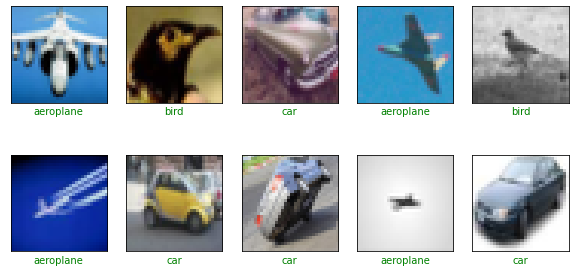

In [4]:
class_names = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
  indices = np.random.choice(range(x.shape[0]), 10, replace = False)

  x = x[indices]
  y = y[indices]
  p = p[indices]
  
  plt.figure(figsize = (10, 5))
  for i in range(10):
    plt.subplot(2, 5, 1+i)
    plt.imshow(x[i])
    plt.xticks([])
    plt.yticks([])
    col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
    plt.xlabel(class_names[np.argmax(p[i])], color = col)
  plt.show()

show_random_examples(x_train, y_train, y_train)

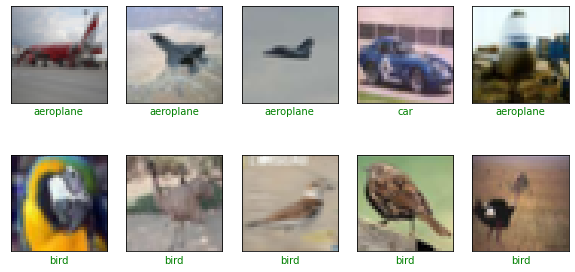

In [5]:
show_random_examples(x_test, y_test, y_test)

# Creating Model

In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
  def add_conv_block(model, num_filters):
    model.add(Conv2D(num_filters, 3, activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(Conv2D(num_filters, 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))
    model.add(Dropout(0.5))
    return model
  
  model = tf.keras.models.Sequential()
  model.add(Input(shape = (32, 32, 3)))

  model = add_conv_block(model, 32)
  model = add_conv_block(model, 64)
  model = add_conv_block(model, 128)

  model.add(Flatten())
  model.add(Dense(3, activation='softmax'))
  model.compile(
      loss = 'categorical_crossentropy',
      optimizer = 'adam', metrics = ['accuracy']
  )
  return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        2

# Training the Model

In [7]:
h = model.fit(
    x_train/255., y_train, 
    validation_data = (x_test/255., y_test),
    epochs= 10, batch_size = 128,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
                 tf.keras.callbacks.ModelCheckpoint(
                     'models/model_{val_accuracy:.3f}.h5',
                     save_best_only = True, save_weights_only = False,
                     monitor = 'val_accuracy'
                 )            
    ]
)

Train on 15000 samples, validate on 3000 samples
Epoch 1/10
15000/15000 [==============================] - 66s 4ms/sample - loss: 0.9294 - accuracy: 0.6664 - val_loss: 2.3443 - val_accuracy: 0.3333
Epoch 2/10
15000/15000 [==============================] - 63s 4ms/sample - loss: 0.5506 - accuracy: 0.7787 - val_loss: 3.2141 - val_accuracy: 0.3333
Epoch 3/10
15000/15000 [==============================] - 67s 4ms/sample - loss: 0.4886 - accuracy: 0.8033 - val_loss: 2.3136 - val_accuracy: 0.5333
Epoch 4/10
15000/15000 [==============================] - 69s 5ms/sample - loss: 0.4531 - accuracy: 0.8204 - val_loss: 0.7531 - val_accuracy: 0.6970
Epoch 5/10
15000/15000 [==============================] - 69s 5ms/sample - loss: 0.4165 - accuracy: 0.8365 - val_loss: 0.4274 - val_accuracy: 0.8340
Epoch 6/10
15000/15000 [==============================] - 69s 5ms/sample - loss: 0.3768 - accuracy: 0.8537 - val_loss: 0.4000 - val_accuracy: 0.8510
Epoch 7/10
15000/15000 [==============================] -

# Final Predictions

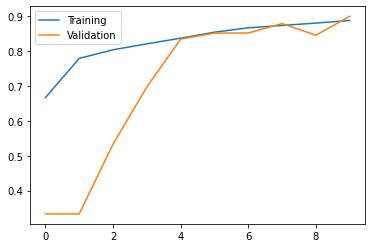

In [8]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)), accs, label = 'Training')
plt.plot(range(len(accs)), val_accs, label = 'Validation')
plt.legend()
plt.show()

In [12]:
model = tf.keras.models.load_model('models/model_0.899.h5')

In [13]:
preds = model.predict(x_test/255.)

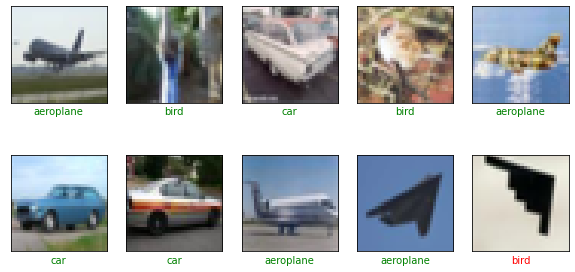

In [15]:
show_random_examples(x_test, y_test, preds)